In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Install **fastbook** to access Bing Search utility functions

In [2]:
!pip install -Uqq fastbook

Import modules

In [3]:
from fastai.vision.all import *
from fastbook import *

Set up Bind access key

In [4]:
bing_search_key = 'dfa9d5723a5a47cc8ac76d460bb8551e'

Use Bing Search to search for a few images for sanity checking results.

In [5]:
results = search_images_bing(bing_search_key, 'grizzly bear', max_images=1)

Get content URLs. **Note** - Bing API has changed since FastAI book was published; it specifies the attribute name as 'content_url' instead of 'contentUrl'

In [6]:
ims = results.attrgot('contentUrl')
len(ims)

1

In [88]:
ims

(#1) ['https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg']

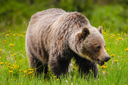

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'grizzly','black','brown','panda','polar','teddy'
path = Path('bears')
if not path.exists(): path.mkdir()
for o in bear_types: 
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    print('Searching for ', o, ' bear images')
    results = search_images_bing(bing_search_key, f'{o} bear', max_images=150)
    download_images(dest, urls=results.attrgot('contentUrl'))

Searching for  grizzly  bear images
Searching for  black  bear images
Searching for  brown  bear images
Searching for  panda  bear images
Searching for  polar  bear images
Searching for  teddy  bear images


In [38]:
fns = get_image_files(path)
fns

(#833) [Path('bears/teddy/04b99bc4-52f0-42b5-a6aa-127ab60a8844.jpg'),Path('bears/teddy/14e05590-9942-420e-9a79-5542467a2fc8.jpg'),Path('bears/teddy/21be2249-256d-4f7d-9a60-5822605da00b.png'),Path('bears/teddy/c769ed4b-c557-45ef-8f88-29c1a27bb99f.jpg'),Path('bears/teddy/66aee61b-77c5-4092-beaa-37a73e858d34.jpg'),Path('bears/teddy/4e01a67f-c688-4d63-bab5-11c22ca5b078.jpg'),Path('bears/teddy/4dd65e9f-cad2-4a4a-b70e-af2d682e6a71.png'),Path('bears/teddy/dbade862-7e46-482d-b412-4ce42c68f2ad.png'),Path('bears/teddy/b078be72-fbee-412a-a20d-027c5d0de407.jpeg'),Path('bears/teddy/ed711845-f77d-4dcf-93bc-f0f913249ba7.jpg')...]

In [40]:
failed = verify_images(fns)
len(failed)

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


0

In [41]:
failed.map(Path.unlink);

In [42]:
len(fns)

833

In [43]:
bears = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        item_tfms=Resize(128))

In [44]:
dls = bears.dataloaders(path)

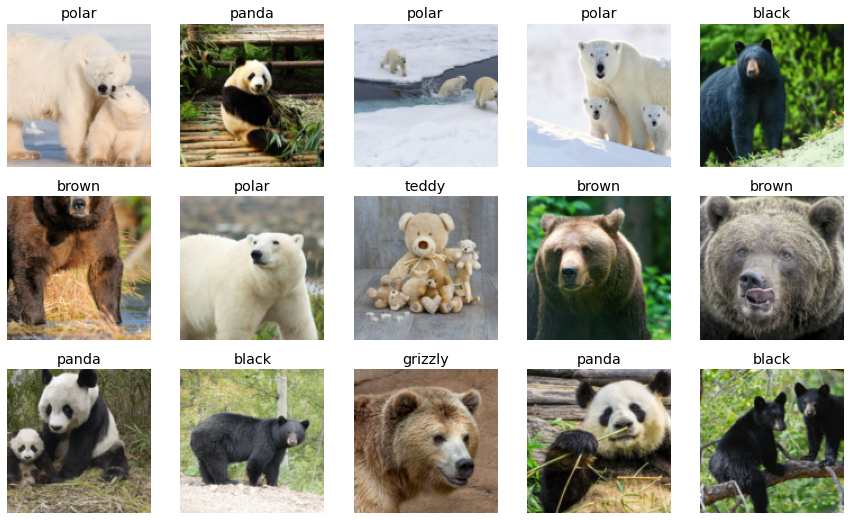

In [45]:
dls.train.show_batch(max_n=15, nrows=3)

In [46]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))

In [47]:
dls = bears.dataloaders(path)

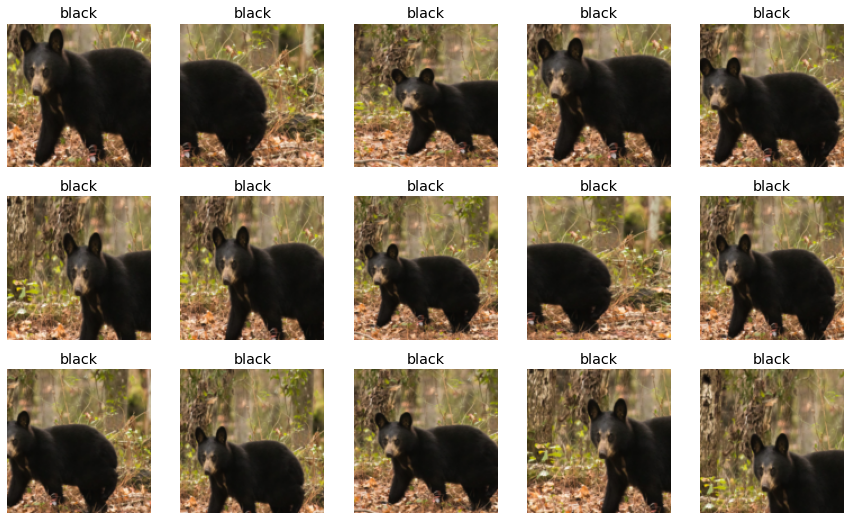

In [48]:
dls.train.show_batch(max_n=15, nrows=3, unique=True)

In [49]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)

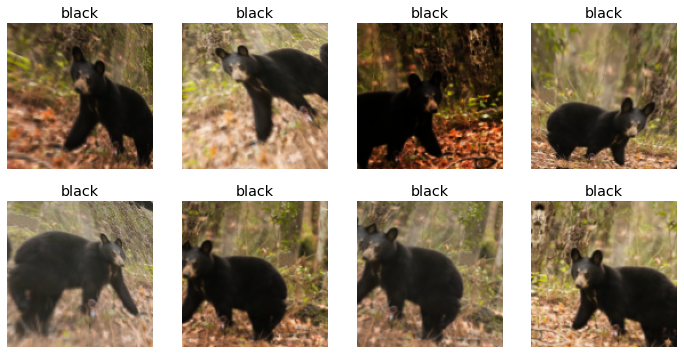

In [50]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [51]:
bears = bears.new(
        item_tfms=RandomResizedCrop(224, min_scale=0.5),
        batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [52]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.902873,0.330047,0.156627,01:08


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.509416,0.264825,0.132530,01:08
1,0.432004,0.281262,0.126506,01:07
2,0.399536,0.296601,0.126506,01:08
3,0.350580,0.296248,0.150602,01:08


/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Print the confusion matrix. 

Not surprisingly, the errors are mainly from misclassifcation of grizzly/brown bears. 6 brown bears are misclassified as grizzlies, and 12 grizzlies as brown. 1 black bear is misclassified as grizzly.

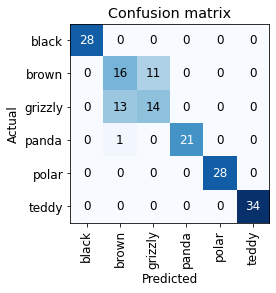

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Show top losses. Title of each image shows: prediction, actual, loss, probability of actual class. 

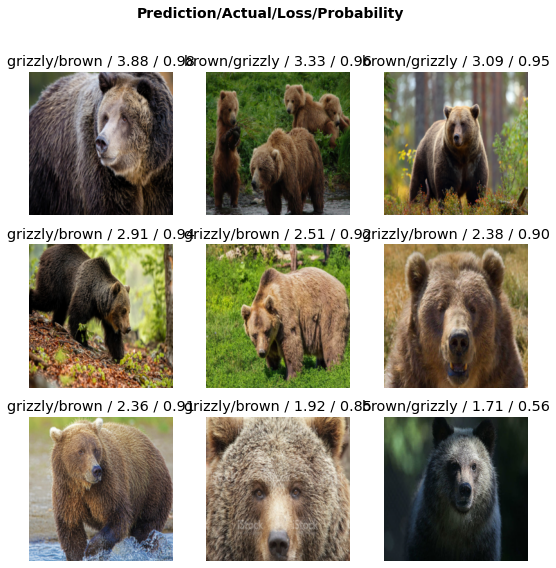

In [54]:
interp.plot_top_losses(9, nrows=3)

# Data cleanup

ImageClassifierCleaner allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

In [55]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


To delete miclassified images from data set run below cell.

In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

To move miclassified images from category to another run below cell.

In [36]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) 

# Using the Model for Inference

Save trained model in 'bears.pkl'

In [60]:
learn.export(fname='bears.pkl')

Verify model was saved successfully.

In [66]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bears.pkl')]

Load saved model.

In [68]:
learn_inf = load_learner(path/'bears.pkl')

Use model to predict. Predicted label is 'grizzly', output tensor index is 2. Using the output tensor index we can see the probability assigned to 'grizzly' is 0.56258

In [69]:
learn_inf.predict('images/grizzly.jpg')

('grizzly',
 TensorBase(2),
 TensorBase([3.8058e-04, 4.3675e-01, 5.6258e-01, 1.4306e-05, 6.1509e-05, 2.1741e-04]))

View model vocabulary (classes)

In [70]:
learn_inf.dls.vocab

['black', 'brown', 'grizzly', 'panda', 'polar', 'teddy']

In [ ]:
# Creating a Notebook App from the Model


In [72]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [80]:
out_pl = widgets.Output() 

In [73]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [85]:
lbl_pred = widgets.Label()

In [82]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: 
        display(img.to_thumb(128,128))
        pred, pred_idx, probs = learn_inf.predict(img)
        lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [83]:
btn_run.on_click(on_click_classify)

In [86]:
VBox([widgets.Label('Select your bear!'),
          btn_upload, btn_run, out_pl, lbl_pred])

# Turning Your Notebook into a Real App

In [89]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.10.0
    Uninstalling jupyter-core-4.10.0:
      Successfully uninstalled jupyter-core-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.4.0 OK
